In [ ]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr

import kdephys.utils as ku
import kdephys.hypno as kh
import kdephys.pd as kpd
import ipywidgets as wd
import kdephys.ssfm.v4 as ss
import kdephys.xr as kx

# Use Widgets to get Info

In [2]:
subject = wd.Text(value='', description='Subject:')
subject

Text(value='', description='Subject:')

In [3]:
block_id = wd.Text(value='', description='Block:')
block_id

Text(value='', description='Block:')

In [4]:
eeg_chan = wd.IntText(
    value=1,
    description='EEG-Channel:',
    disabled=False
)
eeg_chan

IntText(value=1, description='EEG-Channel:')

# Score and Plot any Given Day

In [2]:
subject = 'ACR_12'
block_id = 'laser1-bl'
eeg_chan = 1
t1 = 0
t2 = 14400

In [4]:
block_path  = Path('/Volumes/opto_loc/Data/' + subject + '/' + subject + '-' + block_id)

def load_scoring_data(emg_chan=1):
    eeg = kx.io.get_data(block_path, store='EEGr', channel=[1,2], t1=t1, t2=t2)
    emg = kx.io.get_data(block_path, store='EMGr', channel = [1,2], sel_chan=emg_chan, t1=t1, t2=t2)
    return eeg, emg

eeg, emg = load_scoring_data()

read from t=0s to t=15913.78s
Using 1017.2526 Hz as SEV sampling rate for EEGr
read from t=0s to t=15913.78s
Using 1017.2526 Hz as SEV sampling rate for EMGr


In [7]:
def get_bp_features(eeg, bp_def, window_length=2, overlap=0, chan=2):
    spg = kx.spectral.get_spextrogram(eeg, window_length=window_length, overlap=overlap)
    spg = spg.sel(channel=chan)
    bp_set = kx.spectral.get_bp_set(spg, bp_def)
    return bp_set, spg

In [10]:
b, s = get_bp_features(eeg, ss.bp_def_v4)

In [ ]:
eeg

/home/kdriessen/github_t2/kdephys/kdephys/ssfm/v4.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_df = avg_df.append(mean, ignore_index=True)
/home/kdriessen/github_t2/kdephys/kdephys/ssfm/v4.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_df = avg_df.append(mean, ignore_index=True)
/home/kdriessen/github_t2/kdephys/kdephys/ssfm/v4.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_df = avg_df.append(mean, ignore_index=True)
/home/kdriessen/github_t2/kdephys/kdephys/ssfm/v4.py:155: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_df = avg_df.append(mean, ignore_index=True)
/home/kdriessen/github_t2/kdephys/kd

passing indexing error (starts_and_ends)
passing indexing error (starts_and_ends)
passing indexing error (starts_and_ends)


/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:37: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sample_period = mode(np.diff(da.datetime.values)).mode[0]
/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:37: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.


KeyError: 0

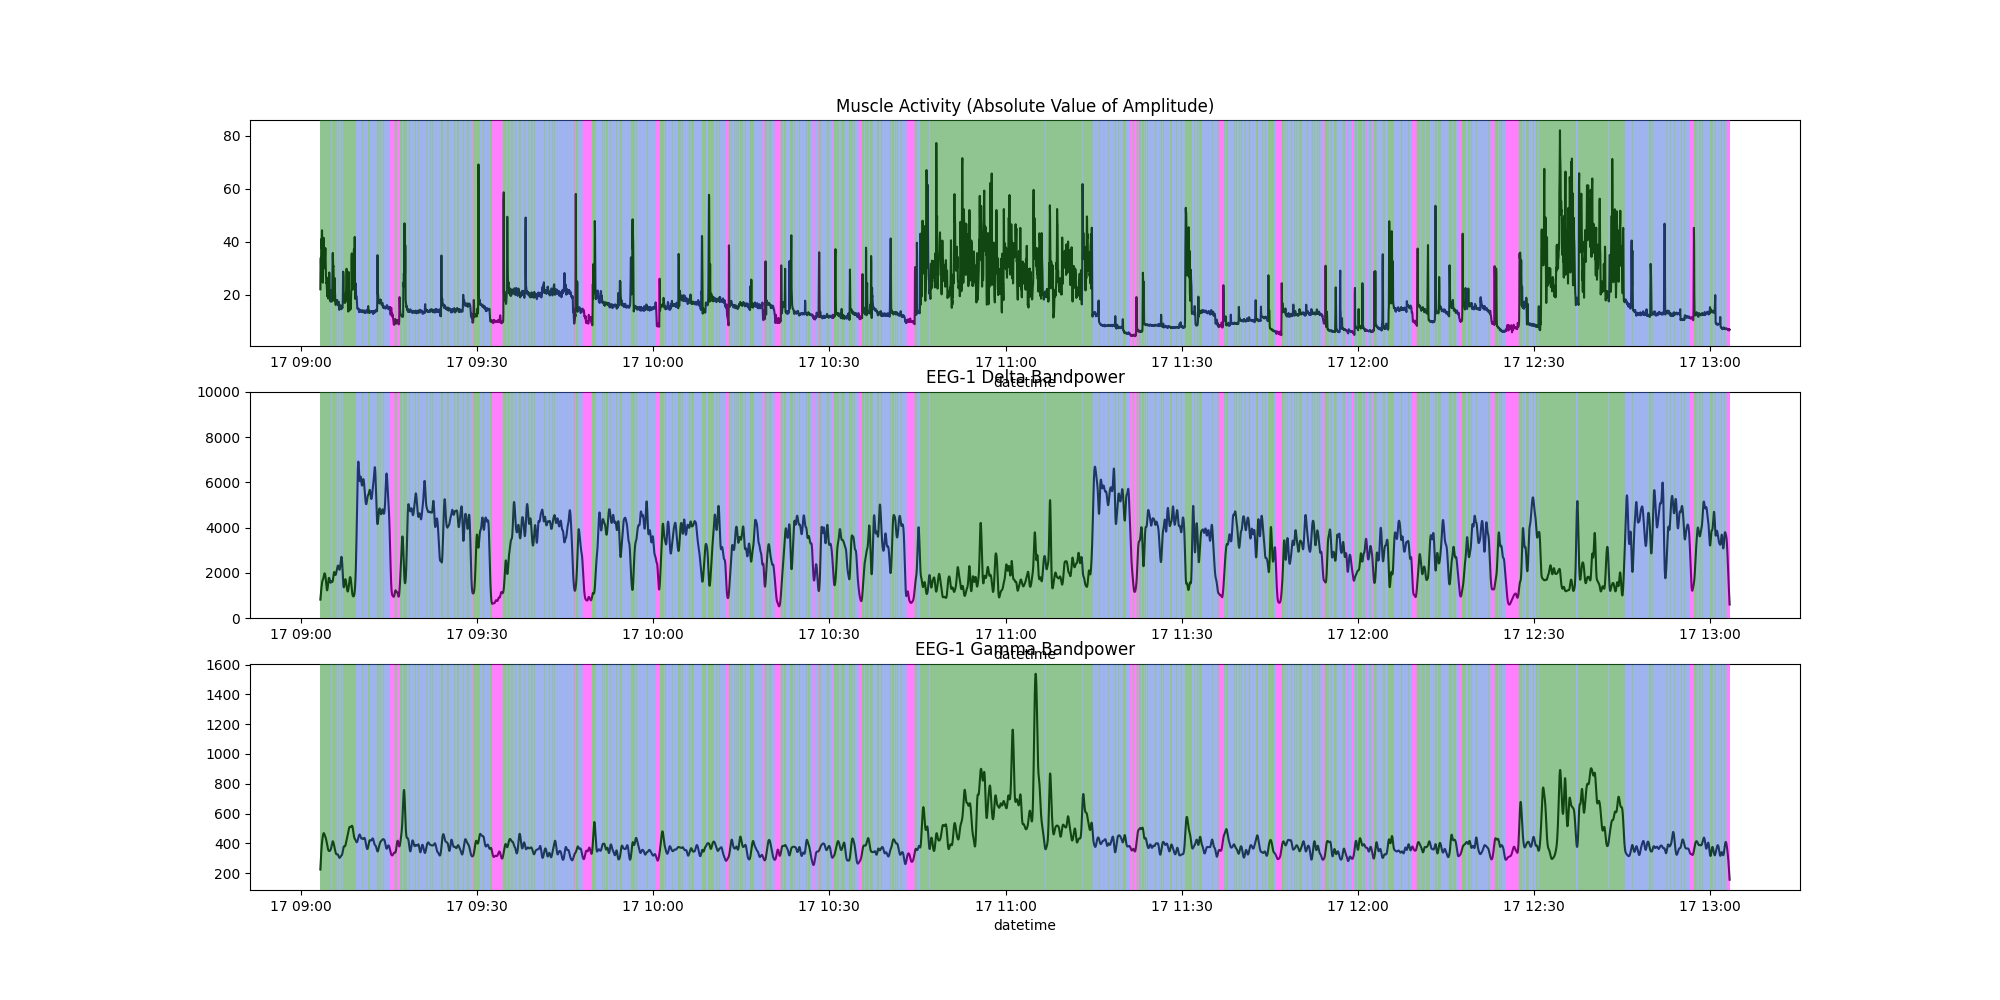

In [11]:
def autoscore(eeg, emg, chan=eeg_chan):
    return ss.ssfm_v4(eeg, emg, chan)

hypno, fig = ss.ssfm_v4(eeg, emg, )

In [ ]:

min = eeg.datetime.values.min()
max = eeg.datetime.values.max()
total_days = np.arange(min.astype('datetime64[D]'), max.astype('datetime64[D]')+ np.timedelta64(1, 'D'), np.timedelta64(1, 'D'))
"Range of all loaded data: " + str(min.astype('datetime64[m]')) + "   to   " + str(max.astype('datetime64[m]'))

In [21]:
day = wd.Dropdown(
    options=total_days,
    value=total_days[0],
    description='Day:',
    disabled=False,
)
day

Dropdown(description='Day:', options=(numpy.datetime64('2022-08-05'), numpy.datetime64('2022-08-06'), numpy.da…

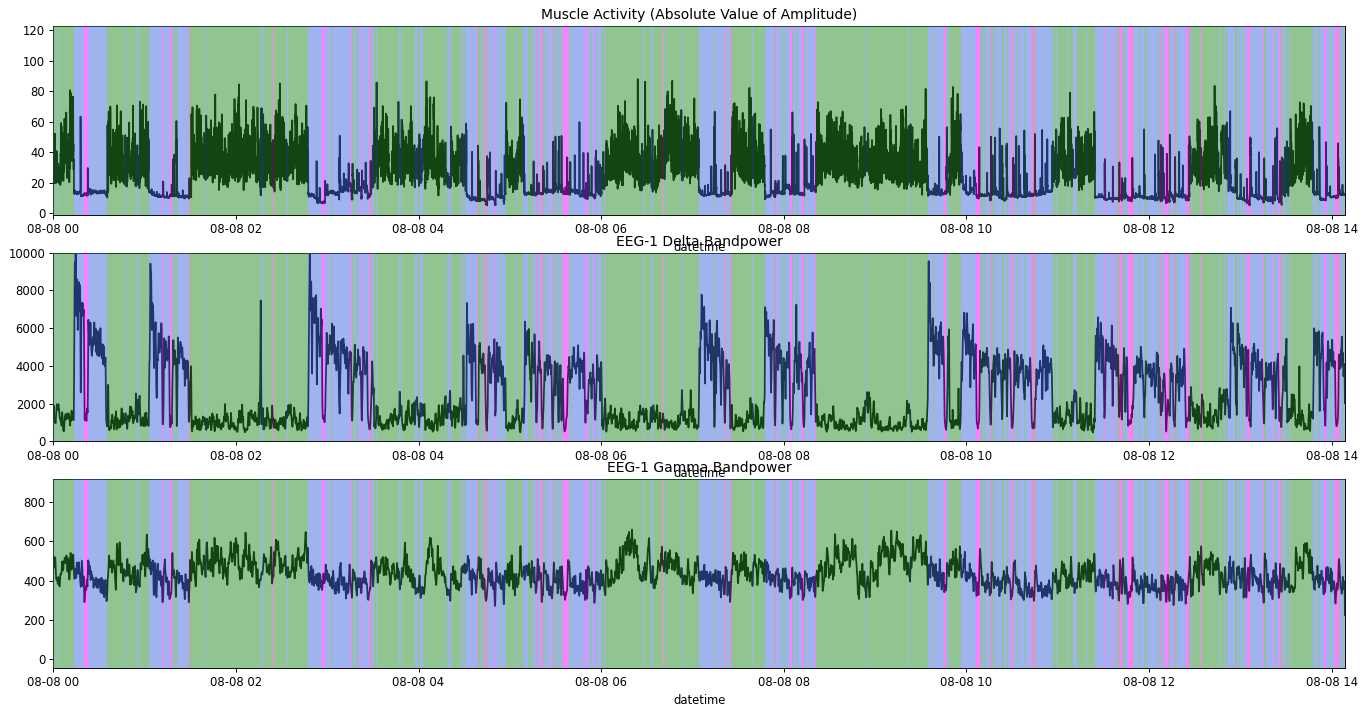

In [80]:
%matplotlib widget
trim_start = day.value
trim_end = day.value + np.timedelta64(24, 'h')

trim_start = min if trim_start < min else trim_start
trim_end = max if trim_end > max else trim_end

fig.axes[0].set_xlim(trim_start, trim_end);
fig.axes[1].set_xlim(trim_start, trim_end);
fig.axes[2].set_xlim(trim_start, trim_end);
fig

# Asleep or Awake Just Before Lights-On?

In [78]:
frac_oc = []
for d in total_days:
    start = pd.Timestamp(str(d) + 'T06:00:00')
    end = pd.Timestamp(str(d) + 'T09:00:00')
    h = hypno[(hypno.end_time >= start) & (hypno.end_time < end)]
    if len(h) > 0:
        time_in_wake = h.fractional_occupancy()['Wake']*100
        frac_oc.append(time_in_wake)
    else:
        frac_oc.append(0)

In [79]:
f, ax = plt.subplots(figsize=(10,6))
plt.scatter(total_days, frac_oc)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …